# The structure is the message: preserving experimental context through tensor decomposition

<h3 style="text-align: center;">Z. Cyrillus Tan, Aaron S. Meyer</h3>

In this demonstration, we provide an example on how to apply tensor methods to a biological dataset.

## 1. Import data and structure it to a tensor format

First, we import the example dataset.

In [1]:
import numpy as np
import pandas as pd
from os.path import join, dirname

data = pd.read_csv("example_drug_data.csv", 
                   delimiter=",", comment="#", index_col=0, header=[0, 1])
data

Alfazumab                                         Bravociclib  \
              1 hr      3 hr      6 hr     12 hr     24 hr        1 hr   
Brain       7.5931  -74.0560 -156.3267 -152.0899 -129.2603     69.7114   
Skin       96.4908   97.6188  135.4522  106.3627  107.4902     84.3421   
Pancreas   82.8958   41.7587   43.6539    9.7820   -3.6321    116.1266   
Liver      54.0536   -2.0641  -29.5443  -51.6633  -55.9508    102.3161   
Heart     176.2525  118.8718  117.1203   95.2692  133.7000    126.5419   
Colon      45.5757  -33.6277 -102.2309 -101.4290  -71.5326     80.1902   
Kidney     90.7719   82.5750  116.1591   86.8304   76.0428     77.3614   

                                                  ... Echoxacin            \
              3 hr      6 hr     12 hr     24 hr  ...      1 hr      3 hr   
Brain     111.0545  177.4723  161.4991  157.9950  ...   87.7958  200.3265   
Skin       68.4413   80.3329   67.1187   80.8065  ...   58.7727   19.6130   
Pancreas  123.8453  163.5675  149.8666  175.2404  ...  120.0887  172.2481   
Liver     122.6016  172.1183  158.7541  176.4939  ...  112.8466  189.4797   
Heart     127.0990  179.5757  136.0497  130.0312  ...  121.8980  182.4849   
Colon     113.8835  178.9411  155.4155  148.6795  ...   94.3906  200.4200   
Kidney     66.4917   78.0255   65.8033   83.3234  ...   73.4567   80.2512   

                                       Foxtrotolol                     \
              6 hr     12 hr     24 hr        1 hr     3 hr      6 hr   
Brain     353.3183  317.5187  283.2818    -28.2758 -22.8253  -26.9893   
Skin        9.9165   -1.6546   -5.6995    -61.4324 -59.4331  -72.4681   
Pancreas  215.8126  226.1064  323.9284    -57.6145 -32.3156  -51.3740   
Liver     269.7720  268.1009  331.7243    -46.3147 -26.0519  -40.3760   
Heart     279.9835  239.0031  246.0975    -97.8848 -77.1348 -101.4701   
Colon     348.5009  308.1313  276.5570    -43.5885 -35.1011  -43.4352   
Kidney     69.3572   83.7880  172.3019    -47.7500 -26.8817  -43.6549   

                            
            12 hr    24 hr  
Brain    -20.9940 -24.8508  
Skin     -62.6582 -80.3741  
Pancreas -23.2484  13.8744  
Liver    -18.4811   9.3109  
Heart    -73.2257 -64.2342  
Colon    -32.9590 -35.0784  
Kidney   -19.8480  12.6196  

[7 rows x 30 columns]

Although this multiindex format can represent the data correctly, analyzing them as a spreadsheet/matrix muddles the relationship of drugs and time points. To better understand the signals in this datasets, we first convert the dataset into tensor format. The original data has three modes: Organs, Drugs, and Time points, each having 7, 6, and 5 entries.

In [2]:
# Retrieve mode axes information
shape = (7, 6, 5)
axes_names = ["Organs", "Drugs", "Times"]
organs = data.index.tolist()
drugs = data.columns.get_level_values(0).unique().tolist()
times = data.columns.get_level_values(1).unique().tolist()
entry_names = [organs, drugs, times]
print(entry_names)

# Now convert the data into a three mode tensor
tensor = data.to_numpy().reshape(*shape)
tensor

[['Brain', 'Skin', 'Pancreas', 'Liver', 'Heart', 'Colon', 'Kidney'], ['Alfazumab', 'Bravociclib', 'Charlivir', 'Deltatinib', 'Echoxacin', 'Foxtrotolol'], ['1 hr', '3 hr', '6 hr', '12 hr', '24 hr']]


array([[[   7.5931,  -74.056 , -156.3267, -152.0899, -129.2603],
        [  69.7114,  111.0545,  177.4723,  161.4991,  157.995 ],
        [  68.0527,  130.6083,  210.7125,  206.7382,  213.4184],
        [   0.5923,   80.0086,  179.5254,  144.0355,   87.8173],
        [  87.7958,  200.3265,  353.3183,  317.5187,  283.2818],
        [ -28.2758,  -22.8253,  -26.9893,  -20.994 ,  -24.8508]],

       [[  96.4908,   97.6188,  135.4522,  106.3627,  107.4902],
        [  84.3421,   68.4413,   80.3329,   67.1187,   80.8065],
        [  47.7073,   56.7609,   56.444 ,   71.3942,  124.8541],
        [ -41.5447,  -85.8681, -117.5078, -127.2689, -174.8336],
        [  58.7727,   19.613 ,    9.9165,   -1.6546,   -5.6995],
        [ -61.4324,  -59.4331,  -72.4681,  -62.6582,  -80.3741]],

       [[  82.8958,   41.7587,   43.6539,    9.782 ,   -3.6321],
        [ 116.1266,  123.8453,  163.5675,  149.8666,  175.2404],
        [  58.2814,   41.5263,   94.9442,   68.5988,  -16.8659],
        [  -8.7859,  

## 2. Perform CP decomposition on the data

Now we perform a CP (also called PARAFAC) decomposition on this tensor. Here, we choose 4 components.

In [3]:
from tensorly.decomposition import parafac

cp = parafac(tensor, 4)

In `TensorLy` package, the results of CP is stored into two sets of values, weights and factors. Weights is a vector of values, and factors is a set of factor matrices.

In [4]:
cp[0]

array([1., 1., 1., 1.])

In [5]:
cp[1]

[array([[-2.34586322e+02,  3.98803407e+00, -1.42942614e+02,
          2.99688580e+00],
        [-4.65631970e+02,  2.04895187e+01,  3.45327946e+01,
          1.95890354e+00],
        [-5.36243117e+02, -6.54655734e+01, -2.63043379e+01,
          3.85363104e+00],
        [-4.31239845e+02, -4.88757941e+01, -6.53530897e+01,
          4.00734258e+00],
        [-8.12440799e+02, -2.82942795e+01, -9.25077643e+01,
         -5.01763110e+00],
        [-3.60087842e+02, -1.49909846e+00, -1.40837825e+02,
          6.79332049e-01],
        [-4.42593166e+02, -5.80553684e+01,  1.82299883e+01,
          1.67272249e-01]]),
 array([[-0.48981349,  0.27285009,  1.27592464,  2.25235801],
        [-0.40854262, -0.15778073, -0.74029523, -2.10675503],
        [-0.13420475,  1.54395504, -0.89293116, -4.9903648 ],
        [ 0.06242462, -2.16139963, -1.62082448,  3.21441368],
        [-0.33365878, -1.28356907, -2.02920754, -2.29750326],
        [ 0.29353388, -0.63852021, -0.04868366, -0.07922179]]),
 array([[ 0.423

## 3. Choosing the number of components

<AxesSubplot:xlabel='Num of Comps.', ylabel='Error'>

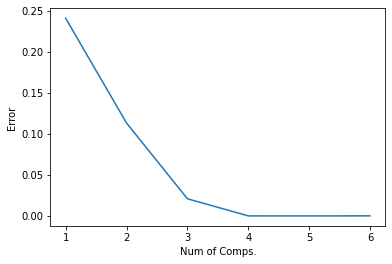

In [6]:
import seaborn as sns
from tensorly.cp_tensor import CPTensor

def error(original, res):
    if isinstance(res, CPTensor):
        res = res.to_tensor()
    return np.sum((original - res)**2) / np.sum(original**2)

errors = pd.DataFrame(columns=["Num of Comps.", "Error"])
for rr in np.arange(1, 7):
    errors.loc[len(errors)+1] = [rr, error(tensor, parafac(tensor, rr))]

sns.lineplot(data=errors, x="Num of Comps.", y="Error", markers="o")

In [7]:
rank = 3
cp = parafac(tensor, rank)

### Compare CP and PCA performance

The number of components chosen directly relates to the data compression efficiency and fidelity trade-off. Basically, when we choose more components, the reconstructed tensor has lower error, but with the cost of needing more parameters. We compare this relationship between CP and principal component analysis (PCA) performed on the original flattened matrix.

In [8]:
reduction = pd.DataFrame({'Size': [], 'Error': [], 'Method': [], 'Data': []})

# Add CP reduction
for rr in np.arange(1, 10):
    reduction = reduction.append({
                'Size': rr * np.sum(tensor.shape),
                'Error': error(tensor, parafac(tensor, rr, tol=1e-09)),
                'Method': "CP",
                'Data': 'Original',
              },
              ignore_index=True)

In [9]:
from sklearn.decomposition import PCA

flatten = tensor.reshape(tensor.shape[0], -1)
pca = PCA(n_components=flatten.shape[0])
pca.fit(flatten)
pca_errors = 1 - np.cumsum(pca.explained_variance_ratio_)
pca_sizes = np.sum(flatten.shape) * np.arange(1, flatten.shape[0] + 1)
for rr in range(flatten.shape[0]-1):
    reduction = reduction.append({
            'Size': pca_sizes[rr],
            'Error': pca_errors[rr],
            'Method': "PCA",
            'Data': 'Original',
          },
          ignore_index=True)

<AxesSubplot:xlabel='Size', ylabel='Error'>

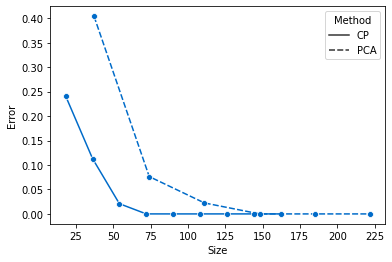

In [10]:
sns.lineplot(data=reduction, x="Size", y="Error", style="Method", marker="o", color="#006BC9")

As we can see here, CP compresses the data more efficiently than PCA. Note that in the case, we cannot compare an n-component CP and an n-component PCA directly, as they are different in compression efficiency.

Nonetheless, 

CP decomposition is not automatically better

In [11]:
# Shuffle the chords / columns
col_tensor = tensor.reshape(tensor.shape[0], -1)
col_tensor = col_tensor[:, np.random.permutation(col_tensor.shape[1])]
col_tensor = col_tensor.reshape(*tensor.shape)

# Shuffle all numbers
rng = np.random.default_rng(123)
rand_tensor = rng.permutation(tensor.flatten()).reshape(*tensor.shape)

In [12]:
for rr in np.arange(1, 13):
    reduction = reduction.append({
                'Size': rr * np.sum(col_tensor.shape),
                'Error': error(col_tensor, parafac(col_tensor, rr, tol=1e-09)),
                'Method': "CP",
                'Data': 'Chords permuted',
              },
              ignore_index=True)
    reduction = reduction.append({
                'Size': rr * np.sum(rand_tensor.shape),
                'Error': error(rand_tensor, parafac(rand_tensor, rr, tol=1e-09)),
                'Method': "CP",
                'Data': 'All permuted',
              },
              ignore_index=True)

    
# Find PCA data reduction
# Chords shuffled
col_flatten = col_tensor.reshape(col_tensor.shape[0], -1)
col_pca = PCA(n_components=col_flatten.shape[0])
col_pca.fit(col_flatten)
col_pca_errors = 1 - np.cumsum(col_pca.explained_variance_ratio_)
col_pca_sizes = np.sum(col_flatten.shape) * np.arange(1, col_flatten.shape[0] + 1)

# All number shuffled
rand_flatten = rand_tensor.reshape(rand_tensor.shape[0], -1)
rand_pca = PCA(n_components=rand_flatten.shape[0])
rand_pca.fit(rand_flatten)
rand_pca_errors = 1 - np.cumsum(rand_pca.explained_variance_ratio_)
rand_pca_sizes = np.sum(rand_flatten.shape) * np.arange(1, rand_flatten.shape[0] + 1)
for rr in range(rand_flatten.shape[0]-1):
    reduction = reduction.append({
        'Size': col_pca_sizes[rr],
        'Error': col_pca_errors[rr],
        'Method': "PCA",
        'Data': 'Chords permuted',
      },
      ignore_index=True)
    reduction = reduction.append({
            'Size': rand_pca_sizes[rr],
            'Error': rand_pca_errors[rr],
            'Method': "PCA",
            'Data': 'All permuted',
          },
          ignore_index=True)

<AxesSubplot:xlabel='Size', ylabel='Error'>

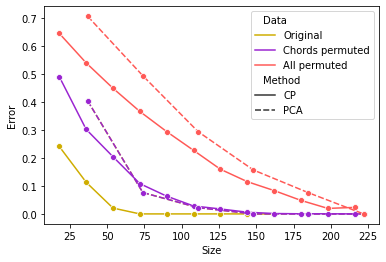

In [13]:
sns.lineplot(data=reduction, x="Size", y="Error", hue="Data", style="Method", marker="o", 
             palette=["#CFAD00", "#9A24D1", "#FF5956"])

## 4. Visualize the results with heatmaps

By default setting of the program, the weights are all 1, and the factor matrices are unnormalized. To visualize these factor matrices, we plot heatmaps for each of them, one for each mode.

In [14]:
import matplotlib
from matplotlib import gridspec, pyplot as plt


def plot_factors(res):
    ddims = len(res[1])
    f = plt.figure(figsize=(5*ddims, 6))
    gs = gridspec.GridSpec(1, ddims, wspace=0.5)
    axes = [plt.subplot(gs[rr]) for rr in range(ddims)]
    comp_labels = [str(ii + 1) for ii in range(rank)]
    
    factors = [pd.DataFrame(res[1][rr],
                        columns=[f"Cmp. {i}" for i in np.arange(1, res[1][rr].shape[1]+1)],
                        index=[organs, drugs, times][rr])
               for rr in range(ddims)]
    
    for rr in range(ddims):
        sns.heatmap(factors[rr], cmap="coolwarm", center=0, 
                    xticklabels=comp_labels, yticklabels=factors[rr].index,
                    cbar=True, vmin=-1.0, vmax=1.0, ax=axes[rr])
        axes[rr].set_xlabel("Components")
        axes[rr].set_title(axes_names[rr])

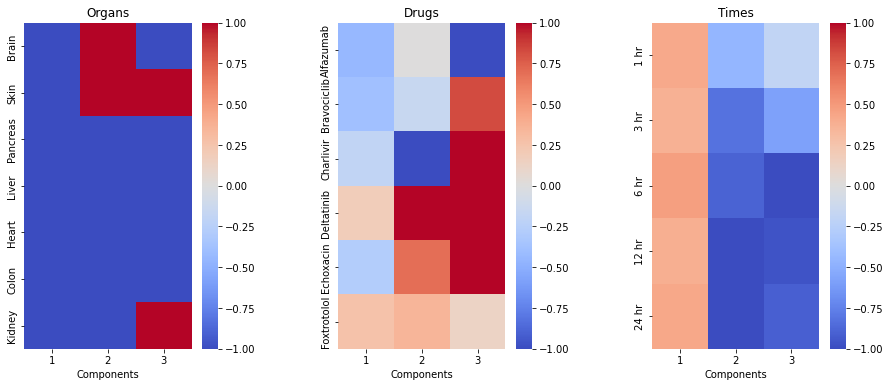

In [15]:
plot_factors(cp)

The colors in some blocks are at the strongest ends because these weights are far beyond +1 and -1, making them hard to compare directly. To better visualize the results, we perform two additional steps to normalize the results:
1. We scale the factor matrix columns so that largest weight in each column is 1. The weights are shifted to `cp[0]`. We sort the components by their weights. These operations will give us an equivalent decomposition.

In [16]:
def factor_scaling(res: CPTensor):
    """ Scale the factor matrices so that they are in plottable scales. """
    for i, factor in enumerate(res.factors):
        scales = np.linalg.norm(factor, ord=np.inf, axis=0)
        res.weights *= scales
        res.factors[i] /= scales

    comp_order = np.flip(np.argsort(res.weights))
    res.weights = res.weights[comp_order]
    for i, factor in enumerate(res.factors):
        res.factors[i] = factor[:, comp_order]
    return res

In [17]:
cp = factor_scaling(cp)

2. We invert the signs of the factor weights of any component that have negative weights on two modes. This will ensure that at most one mode contains strong negative weights.

In [18]:
def sign_indeterminacy(res: CPTensor):
    """ Fix CP decomposition sign indeterminacy by flipping signs in pairs of modes. """
    ddims = len(res[1])
    for rr in range(ddims-1):
        mmeans = np.sign(np.mean(res.factors[rr], axis=0))
        res.factors[rr] *= mmeans[np.newaxis, :]
        res.factors[rr+1] *= mmeans[np.newaxis, :]
    return res

In [19]:
cp = sign_indeterminacy(cp)

See "Interpreting the results" and Fig. 2i to read more about scale indeterminacy and how it relates to result interpretation.

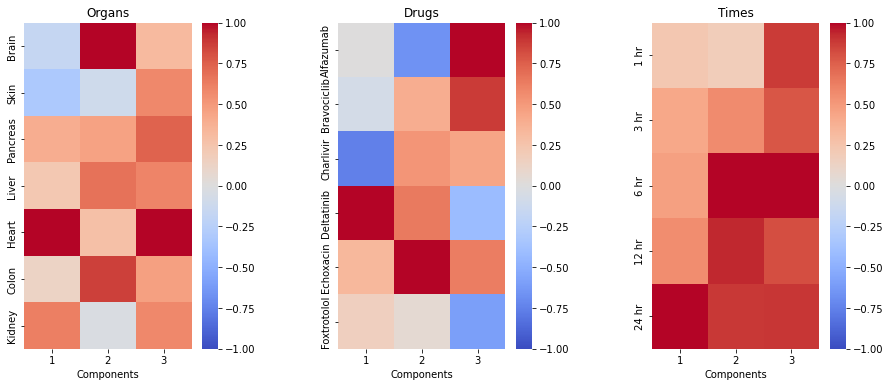

In [20]:
plot_factors(cp) 

## 5. Other options for visualizing the results

Heatmaps are sometimes not the most intuitive way of visualizing weights. Therefore, here we show a few options to demonstrate the tensor decomposition results.

### Looking into one component
To highlight one component, we can make a bar plot for each factor of the three modes:

In [21]:
def plot_one_component(res, i_comp=1):
    ddims = len(res[1])
    f = plt.figure(figsize=(5*ddims, 3))
    gs = gridspec.GridSpec(1, ddims, wspace=0.5)
    axes = [plt.subplot(gs[rr]) for rr in range(ddims)]
    
    bar_colors = ["#3177FF", "#FF644F", "#00AD01"]
    
    for rr in range(ddims):
        sns.barplot(data = pd.DataFrame(data={"Entry": entry_names[rr], "Weight": cp[1][rr][:, i_comp-1]}),
                    x='Entry', y='Weight', color=bar_colors[rr], ax=axes[rr])
        
        axes[rr].set_title(axes_names[rr])
        axes[rr].tick_params(axis='x', rotation=90)
        
    f.suptitle(f"Component {i_comp}")

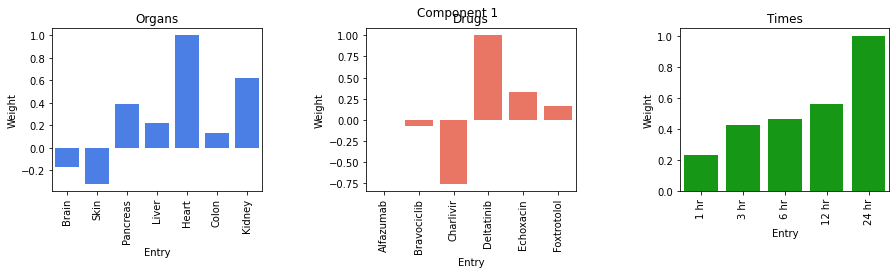

In [22]:
plot_one_component(cp, i_comp=1)

### Looking into one mode
Alternatively, we can also compare the factors across components within one mode. Depending on the nature of the mode, one can either choose a barplot or a lineplot.

Text(0.5, 1.0, 'Drug factors')

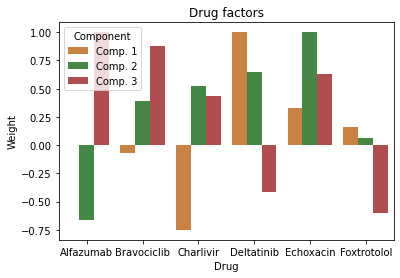

In [23]:
drug_factors = pd.DataFrame(cp[1][1], columns=[f"Comp. {rr}" for rr in np.arange(1, rank+1)], index=drugs)
drug_factors.index.name = "Drug"
drug_factors = drug_factors.reset_index().melt(id_vars=['Drug'], 
                                               value_vars=[f"Comp. {rr}" for rr in np.arange(1, rank+1)],
                                               var_name="Component", value_name='Weight')

sns.barplot(data=drug_factors, x="Drug", y="Weight", hue="Component", 
            palette= ["#E1812C", "#3A923A", "#C03D3E"]).set_title("Drug factors")

Text(0.5, 1.0, 'Time point factors')

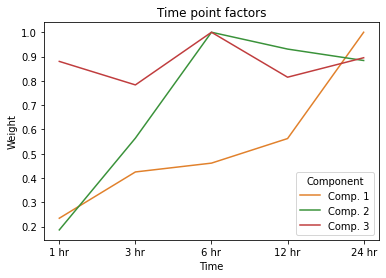

In [24]:
time_factors = pd.DataFrame(cp[1][2], columns=[f"Comp. {rr}" for rr in np.arange(1, rank+1)], index=times)
time_factors.index.name = "Time"
time_factors = time_factors.reset_index().melt(id_vars=['Time'], 
                                               value_vars=[f"Comp. {rr}" for rr in np.arange(1, rank+1)],
                                               var_name="Component", value_name='Weight')

sns.lineplot(data=time_factors, x="Time", y="Weight", hue="Component", 
             palette=["#E1812C", "#3A923A", "#C03D3E"]).set_title("Time point factors")

## 6. Use factor matrix to find associations among organs

Looking into the factor matrix of organs, we can discover associations among their respective cells through associations.

In [25]:
df_organ = pd.DataFrame(data=cp[1][0], columns=[f"Comp. {rr}" for rr in np.arange(1, rank+1)], index=organs)

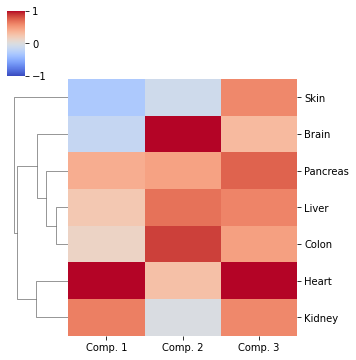

In [26]:
sns.clustermap(df_organ, col_cluster=False, method='average', 
               cmap="coolwarm", vmin=-1.0, vmax=1.0, figsize=(5, 5)) 

## 7. Missing value and imputation test

In [27]:
missing_value_errors = []
missing_value_proportions = [0.0, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95]

for miss_ratio in missing_value_proportions:
    for rep in range(40):
        unmask = np.random.rand(*tensor.shape) < 1 - miss_ratio
        cp_masked = parafac(tensor, 3, mask=unmask)
        recon_error = error(tensor, cp_masked.to_tensor())
        missing_value_errors.append((miss_ratio, recon_error))

missing_value_df = pd.DataFrame(missing_value_errors, columns=["Missing proportion", "Error"])

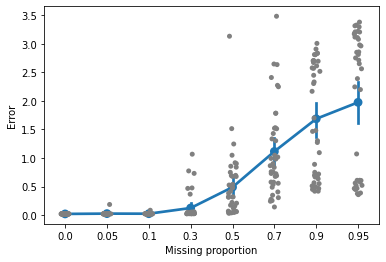

In [28]:
sns.stripplot(data=missing_value_df, x="Missing proportion", y="Error", color="gray")
plot = sns.pointplot(data=missing_value_df, x="Missing proportion", y="Error")

plot.figure.savefig("corruption.svg")

In [29]:
imputation_test = []
for rep in range(30):
    unmask = np.random.rand(*tensor.shape) < 0.8
    # this is equivalent to masking 20% of values to be missing
    for rr in np.arange(1, 13):
        cp_masked = parafac(tensor, rr, mask=unmask)
        fitting_error = error(tensor[unmask], cp_masked.to_tensor()[unmask])
        imputation_error = error(tensor[~unmask], cp_masked.to_tensor()[~unmask])
        imputation_test.append((rr, "Fitting", fitting_error))
        imputation_test.append((rr, "Imputation", imputation_error))

imputation_df = pd.DataFrame(imputation_test, columns=["Components", "Error Type", "Value"])
print(imputation_df)

     Components  Error Type     Value
0             1     Fitting  0.261240
1             1  Imputation  0.174451
2             2     Fitting  0.114299
3             2  Imputation  0.131770
4             3     Fitting  0.020511
..          ...         ...       ...
715          10  Imputation  0.077714
716          11     Fitting  0.000040
717          11  Imputation  0.075012
718          12     Fitting  0.000161
719          12  Imputation  1.869217

[720 rows x 3 columns]


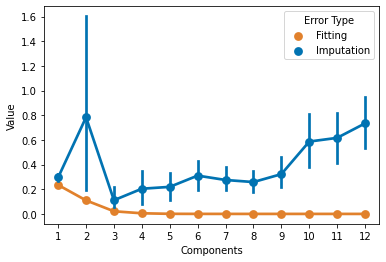

In [30]:
plot = sns.pointplot(data=imputation_df, x="Components", y="Value", hue="Error Type", 
              linestyle=None, palette=["#E1812C", "#0173B2"])
plot.figure.savefig("imputation.svg")

## 8. Logistic regression on the organs

The decomposed factors can be used for binary classification when combined with logistic regression. For example, we try to observe the association between the effect of drug and XXX.

In [31]:
from sklearn.linear_model import LogisticRegression

Logistic regression assigns linear weights to each component, therefore the previous normalization on the organ factor matrix, such as scaling and sign flipping, does not alter the results.

In [32]:
organ_effect = np.array([0, 0, 1, 0, 1, 0, 1])
lr = LogisticRegression().fit(cp[1][0], organ_effect)
lr.score(cp[1][0], organ_effect)

0.8571428571428571

In [33]:
lr.coef_

array([[ 0.88194697, -0.44151518,  0.33957457]])

To estimate the variations of the coefficient, we perform a jackknife resampling.

In [34]:
from sklearn.model_selection import LeaveOneOut
from tensorly.metrics.factors import congruence_coefficient

lr_jackknife = []
for ii in range(tensor.shape[0]):
    # get jackknife indices
    jk = np.delete(np.arange(tensor.shape[0]), [ii])
    jcp = parafac(tensor[jk], 3)
    jcp = factor_scaling(jcp)
    
    # align jackknifed factors with original for comparison    
    jcp = sign_indeterminacy(jcp)
    congru_perm = congruence_coefficient(cp[1][0][jk, :], jcp[1][0])[1]
    jcp.weights = jcp[0][congru_perm]
    for i, factor in enumerate(jcp.factors):
        jcp.factors[i] = factor[:, congru_perm]
    
    # run logistic regression
    lr = LogisticRegression().fit(jcp[1][0], organ_effect[jk])
    lr_jackknife.append(lr.coef_)

lr_coef = pd.DataFrame(np.concatenate(lr_jackknife), columns=[f"Comp. {r}" for r in np.arange(1, rank+1)])
lr_coef = pd.melt(lr_coef, var_name="Factor", value_name="Coefficient")

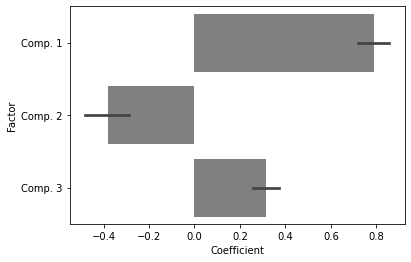

In [35]:
plot = sns.barplot(data=lr_coef, x="Coefficient", y="Factor", orient="h", color="gray")
plot.figure.savefig("logistic.svg")

In [36]:
organ_effect[jk]

array([0, 0, 1, 0, 1, 0])

In [37]:
reduced_data = cp[1][0][:, [2, 0]]
lr_reduced = LogisticRegression().fit(reduced_data, organ_effect)
lr_reduced.score(reduced_data, organ_effect)

0.8571428571428571

In [38]:
cp[1][0][:, [0,1]]

array([[-0.17042685,  1.        ],
       [-0.31705504, -0.10800934],
       [ 0.39091754,  0.45799948],
       [ 0.22380659,  0.67307673],
       [ 1.        ,  0.28122155],
       [ 0.1317451 ,  0.85971262],
       [ 0.62291492, -0.0245926 ]])

### Sparsity (does not work)

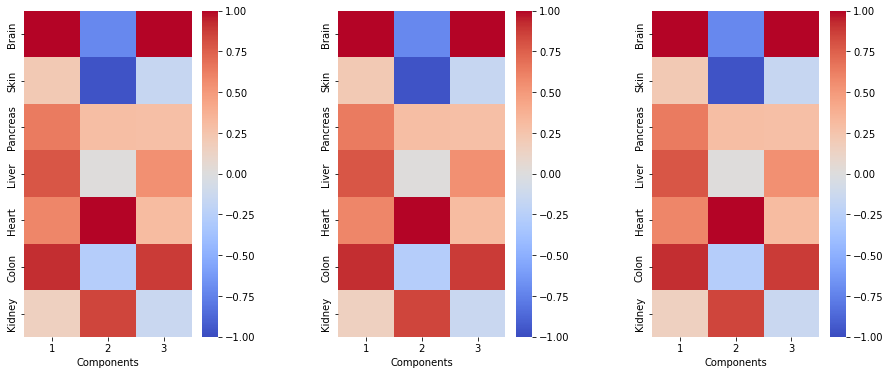

In [39]:
l2_sparsity = [1.0, 5.0, 10.0]
f = plt.figure(figsize=(5*len(l2_sparsity), 6))
gs = gridspec.GridSpec(1, len(l2_sparsity), wspace=0.5)
axes = [plt.subplot(gs[rr]) for rr in range(len(l2_sparsity))]
comp_labels = [str(ii + 1) for ii in range(rank)]

for rr in range(len(l2_sparsity)):
    cp_sparse = parafac(tensor, 3, sparsity=l2_sparsity[rr])[0]
    #print(cp_sparse[0][1])
    #print(cp_sparse[1])
    cp_sparse = factor_scaling(cp_sparse)
    cp_sparse = sign_indeterminacy(cp_sparse)
    
    sparse_factor = pd.DataFrame(cp_sparse[1][0],
                        columns=[f"Cmp. {i}" for i in np.arange(1, 4)],
                        index=organs)
    
    sns.heatmap(sparse_factor, cmap="coolwarm", center=0, 
                xticklabels=comp_labels, yticklabels=sparse_factor.index,
                cbar=True, vmin=-1.0, vmax=1.0, ax=axes[rr])
    axes[rr].set_xlabel("Components")